# IADT Fase 01 ‚Äî Tech Challenge

## Previs√£o de Custos M√©dicos com Modelos de Regress√£o

Este notebook documenta o passo a passo para resolver o desafio de previs√£o de custos m√©dicos, integrando os conhecimentos adquiridos na Fase 01 do curso IADT.

Autor: Victor Nardi Vilella


## 1. Importa√ß√£o das Bibliotecas

Aqui a gente importa as bibliotecas essenciais pra resolver o desafio.  

Cada uma tem seu papel: manipular dados, fazer gr√°ficos, modelar e avaliar o modelo.

- `pandas` e `numpy` ‚Üí manipula√ß√£o de dados, b√°sico de qualquer projeto.
- `matplotlib` e `seaborn` ‚Üí gr√°ficos pra visualizar melhor as distribui√ß√µes, correla√ß√µes e resultados.
- `scikit-learn` ‚Üí separar os dados, criar o modelo de regress√£o e avaliar.
- `statsmodels` ‚Üí pra complementar a valida√ß√£o estat√≠stica, com an√°lise mais robusta (p-value e intervalos de confian√ßa).

Depois de importadas, seguimos pro carregamento e explora√ß√£o do dataset.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento do Dataset

Agora vamos carregar o dataset com os nomes das colunas sugeridas no desafio
  
Primeiro, damos aquela olhada r√°pida no cabe√ßalho, na estrutura e nas estat√≠sticas b√°sicas ‚Äî s√≥ pra garantir que est√° tudo certo antes de seguir.


In [8]:
# Carregando o dataset
df = pd.read_csv('../data/insurance.csv')

# Visualizando as primeiras linhas
print("Primeiras linhas do dataset:")
display(df.head())

# Estrutura do DataFrame
print("Informa√ß√µes do dataset:")
df.info()

# Estat√≠sticas descritivas
print("Estat√≠sticas descritivas:")
display(df.describe())

Primeiras linhas do dataset:


idade     genero     imc  filhos fumante    regiao     encargos
0     19   feminino  27.900       0     sim  sudoeste  16884.92400
1     18  masculino  33.770       1     nao   sudeste   1725.55230
2     28  masculino  33.000       3     nao   sudeste   4449.46200
3     33  masculino  22.705       0     nao  noroeste  21984.47061
4     32  masculino  28.880       0     nao  noroeste   3866.85520

Informa√ß√µes do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   genero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   regiao    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Estat√≠sticas descritivas:


idade          imc       filhos      encargos
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Coment√°rios - An√°lise r√°pida:

Total de registros: 1338

Vari√°veis categ√≥ricas: genero, fumante, regiao

Vari√°veis num√©ricas: idade, imc, filhos, encargos

Sem valores ausentes: nos ajuda muito

## 3. An√°lise Explorat√≥ria de Dados (EDA)

Hora de entender melhor a distribui√ß√£o dos dados e identificar poss√≠veis outliers.

Vamos verificar valores ausentes (mesmo sabendo que n√£o tem), visualizar as distribui√ß√µes e fazer alguns boxplots.

Valores ausentes por coluna:
idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64


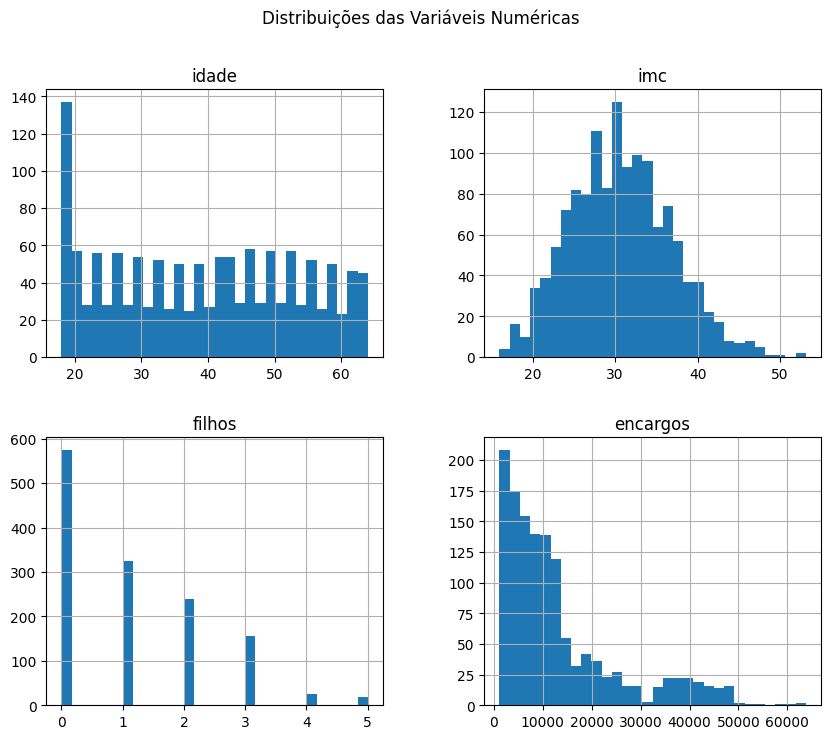

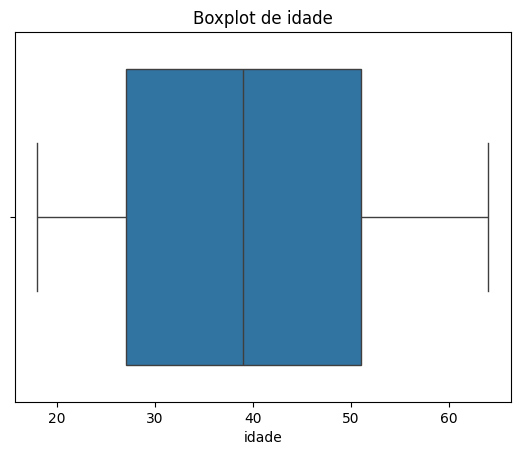

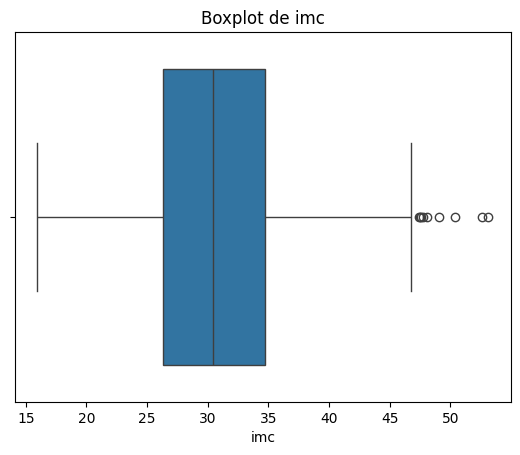

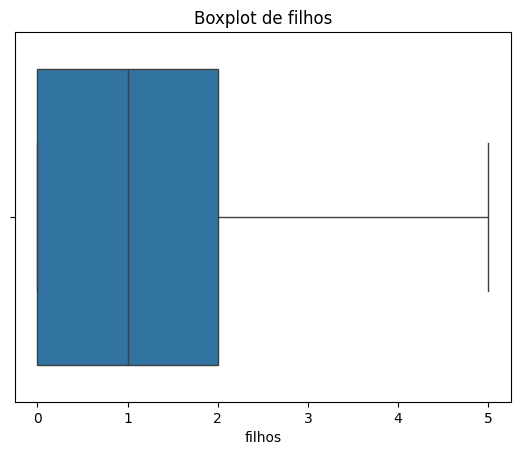

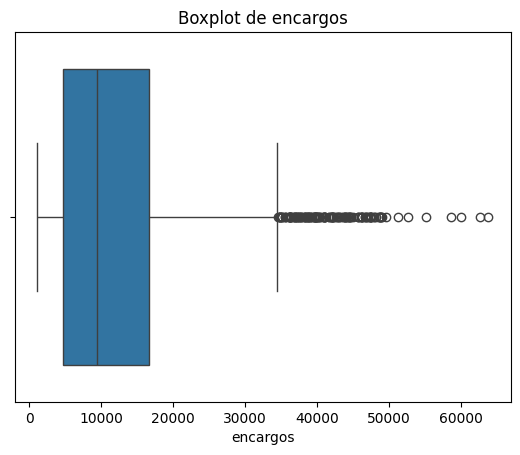

In [9]:
# Verificar novamente se h√° valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Histograma das vari√°veis num√©ricas
df[['idade', 'imc', 'filhos', 'encargos']].hist(bins=30, figsize=(10,8))
plt.suptitle("Distribui√ß√µes das Vari√°veis Num√©ricas")
plt.show()

# Boxplots para detec√ß√£o de outliers
for col in ['idade', 'imc', 'filhos', 'encargos']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

## Interpreta√ß√£o da An√°lise Explorat√≥ria

- **Valores ausentes:** nenhuma coluna com dados faltantes ‚Äî n√£o precisamos fazer imputa√ß√£o ou remo√ß√£o.

- **Distribui√ß√µes:**
  - **Idade:** distribui√ß√£o relativamente uniforme, mais concentrada entre 20 e 40 anos.
  - **IMC:** maioria entre 20 e 40, mas com alguns outliers acima de 45.
  - **Filhos:** maioria com at√© 2 filhos; poucos casos acima de 3.
  - **Encargos:** distribui√ß√£o assim√©trica ‚Äî muitos valores baixos, mas com outliers claros acima de 40 mil.

- **Boxplots:**
  - Mostram presen√ßa de **outliers** importantes, principalmente em `imc` e `encargos`.
  - Decidimos **manter os outliers** por dois motivos: o dataset √© pequeno (1338 entradas) e queremos testar a robustez do modelo.

**Resumo:**  
O dataset est√° **limpo e pronto** para o pr√©-processamento.  
A presen√ßa de outliers ser√° um ponto importante na hora de avaliar a performance e a escolha do modelo.

##  4. Pr√©-processamento dos Dados

Agora precisamos preparar os dados para a modelagem:  
- Transformar vari√°veis **categ√≥ricas** em vari√°veis num√©ricas, usando **One-Hot Encoding**.  
- Separar as **vari√°veis preditoras** (`X`) e a **vari√°vel alvo** (`y`), que no nosso caso √© `encargos`.


In [10]:
# Transformar vari√°veis categ√≥ricas em dummies
df = pd.get_dummies(df, columns=['genero', 'fumante', 'regiao'], drop_first=True)

print("Colunas ap√≥s Encoding:")
print(df.columns)

# Separar vari√°veis preditoras (X) e alvo (y)
X = df.drop('encargos', axis=1)
y = df['encargos']

print("Vari√°veis preditoras (X):")
display(X.head())

print("Vari√°vel alvo (y):")
display(y.head())

Colunas ap√≥s Encoding:
Index(['idade', 'imc', 'filhos', 'encargos', 'genero_masculino', 'fumante_sim',
       'regiao_noroeste', 'regiao_sudeste', 'regiao_sudoeste'],
      dtype='object')
Vari√°veis preditoras (X):


idade     imc  filhos  genero_masculino  fumante_sim  regiao_noroeste  \
0     19  27.900       0             False         True            False   
1     18  33.770       1              True        False            False   
2     28  33.000       3              True        False            False   
3     33  22.705       0              True        False             True   
4     32  28.880       0              True        False             True   

   regiao_sudeste  regiao_sudoeste  
0           False             True  
1            True            False  
2            True            False  
3           False            False  
4           False            False

Vari√°vel alvo (y):


0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: encargos, dtype: float64

## Coment√°rios: Transforma√ß√£o das Vari√°veis Categ√≥ricas

Aplicamos **One-Hot Encoding** para transformar as vari√°veis categ√≥ricas (`genero`, `fumante`, `regiao`) em vari√°veis num√©ricas bin√°rias.

### Por que fizemos isso?

- Modelos de regress√£o, como a Regress√£o Linear, **n√£o entendem vari√°veis categ√≥ricas** ‚Äî eles s√≥ operam com n√∫meros.
- O **One-Hot Encoding** cria colunas bin√°rias (`0` ou `1`) para representar as categorias, **sem atribuir ordens falsas** entre elas.
- Isso evita que o modelo interprete, por exemplo, que `masculino` vale mais ou menos que `feminino` s√≥ porque o n√∫mero associado seria maior ou menor.
- Assim, garantimos que o modelo aprenda de forma **neutra e correta** o impacto de cada categoria na vari√°vel alvo.

---

### Sobre `drop_first=True`

- Mantivemos `drop_first=True` para **evitar multicolinearidade**.  
- Multicolinearidade acontece quando h√° colunas **redundantes**, ou seja, quando uma vari√°vel pode ser **determinada** pelas demais.
- No One-Hot Encoding, se mantivermos todas as categorias, uma delas ser√° automaticamente dedut√≠vel pelas outras ‚Üí gerando **multicolinearidade perfeita**.
- Isso pode:  
  Inflar os erros padr√£o,  
  Distorcer a interpreta√ß√£o dos coeficientes,  
  Prejudicar a estabilidade do modelo.
  
Por isso, ao usar `drop_first=True`, eliminamos uma categoria (de forma arbitr√°ria), reduzimos o n√∫mero de colunas e evitamos esse problema.

---

### O que mudou no dataset?

- Agora, as vari√°veis preditoras (`X`) est√£o todas **num√©ricas** e prontas para o modelo.
- A vari√°vel alvo (`y`) continua sendo `encargos`, o valor que queremos prever.

**Exemplo de vari√°veis transformadas:**
- `genero_masculino`: `True` se for masculino, `False` caso contr√°rio.
- `fumante_sim`: `True` se for fumante.
- `regiao_*`: representa as regi√µes como vari√°veis bin√°rias.


## 5. Divis√£o em Conjuntos de Treinamento e Teste

Agora vamos dividir o dataset para treinar e avaliar o modelo.  
Separar os dados evita que o modelo "decor" os exemplos e permite uma avalia√ß√£o mais realista de sua capacidade de generaliza√ß√£o.

Usaremos **80% dos dados para treino** e **20% para teste**.


In [11]:
from sklearn.model_selection import train_test_split

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Treinamento: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")


Treinamento: 1070 amostras
Teste: 268 amostras


## Coment√°rio: Por que dividir o dataset?

Dividimos o dataset em dois conjuntos:

- **Treinamento (80%)** ‚Üí para o modelo **aprender** os padr√µes a partir dos dados.
- **Teste (20%)** ‚Üí para **avaliar** se o modelo consegue **generalizar** para dados que nunca viu.

Essa separa√ß√£o √© essencial para evitar o **overfitting** ‚Äî quando o modelo "decora" os dados de treino, mas falha ao prever novos casos.

Usamos `random_state=42` para garantir que a divis√£o seja **reprodut√≠vel** ‚Äî ou seja, se rodarmos o c√≥digo novamente, a divis√£o ser√° a mesma.

**Resumo:**  
Separar os dados √© um dos passos mais importantes para validar a **robustez** e a **efic√°cia** do modelo.


## 6. Modelagem Preditiva ‚Äî Regress√£o Linear

Agora vamos criar e treinar o nosso modelo de **Regress√£o Linear**.

Optamos por come√ßar com a Regress√£o Linear por ser um modelo **simples**, **interpret√°vel** e ideal para estabelecer uma **linha de base**.

(Depois, podemos evoluir para modelos mais complexos).


In [12]:
from sklearn.linear_model import LinearRegression

# Inicializar o modelo
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

print("Modelo treinado com sucesso!")


Modelo treinado com sucesso!


## Explica√ß√£o do C√≥digo ‚Äî Modelagem com Regress√£o Linear

- **`modelo = LinearRegression()`** ‚Üí inicializamos o modelo de Regress√£o Linear usando a biblioteca **scikit-learn**.

- **`modelo.fit(X_train, y_train)`** ‚Üí aqui o modelo **aprende** a rela√ß√£o entre as vari√°veis preditoras (`X_train`) e a vari√°vel alvo (`y_train`).

**Resumo:**  
Com essas duas linhas de c√≥digo, o modelo est√° **pronto para fazer previs√µes** com base no que aprendeu a partir dos dados de treinamento.


## 7.Avalia√ß√£o do Modelo

Agora vamos avaliar a performance do modelo com m√©tricas estat√≠sticas e visualiza√ß√µes.  

As principais m√©tricas que vamos usar s√£o:

- **MSE (Erro Quadr√°tico M√©dio)** ‚Üí quanto menor, melhor.
- **RMSE (Raiz do Erro Quadr√°tico M√©dio)** ‚Üí interpreta√ß√£o mais intuitiva, na mesma unidade da vari√°vel `encargos`.
- **R¬≤ (Coeficiente de Determina√ß√£o)** ‚Üí indica o quanto da variabilidade do `encargos` √© explicada pelo modelo (varia de 0 a 1).

Tamb√©m vamos visualizar um gr√°fico de **valores reais vs previstos**.

MSE: 33596915.85
RMSE: 5796.28
R¬≤: 0.78


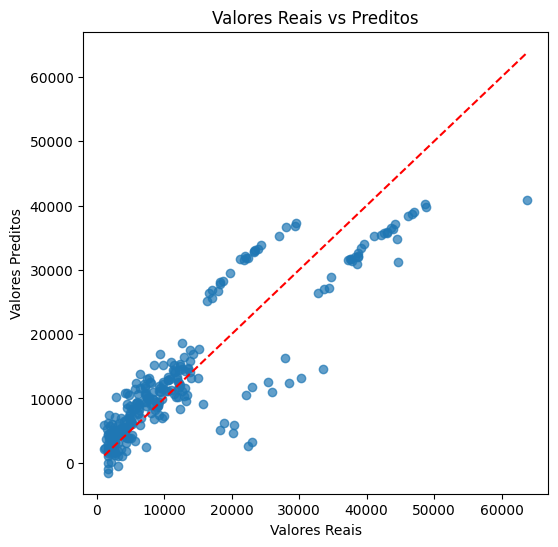

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Fazer previs√µes com os dados de teste
y_pred = modelo.predict(X_test)

# C√°lculo das m√©tricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤: {r2:.2f}")

# Gr√°fico: valores reais vs previstos
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha de refer√™ncia
plt.show()


## Interpreta√ß√£o das M√©tricas de Avalia√ß√£o

### MSE ‚Äî Erro Quadr√°tico M√©dio: `33.596.915,85`

- Mede o **erro m√©dio ao quadrado** entre os valores previstos e os reais.
- Penaliza mais os **erros grandes**.
- Como os encargos chegam a mais de R$ 60 mil, faz sentido o MSE estar na casa dos **milh√µes**.
- **N√£o √© muito intuitivo** de interpretar diretamente.

---

### RMSE ‚Äî Raiz do Erro Quadr√°tico M√©dio: `5.796,28`

- √â a raiz quadrada do MSE e, por isso, fica na **mesma unidade** da vari√°vel `encargos`.
- Significa que, em m√©dia, o modelo **erra cerca de R$ 5.800** pra mais ou pra menos.
- Mais intuitivo para explicar a **precis√£o do modelo**.

---

### R¬≤ ‚Äî Coeficiente de Determina√ß√£o: `0.78`

- Mede o quanto da **varia√ß√£o dos custos m√©dicos** o modelo consegue **explicar**.
- Varia entre **0 e 1**:  
  - **1** ‚Üí modelo perfeito.  
  - **0** ‚Üí modelo in√∫til.  
- Com **0.78**, significa que o modelo explica **78% da varia√ß√£o** nos encargos.

---

### **Resumo:**

Nosso modelo:  
- Tem um erro m√©dio de cerca de **R$ 5.800**.  
- Explica **78%** dos fatores que influenciam os custos m√©dicos.

√â um resultado **satisfat√≥rio**, principalmente para um modelo **simples** e **sem ajustes mais avan√ßados**.


## 8. Valida√ß√£o Estat√≠stica com `statsmodels`

Agora vamos usar o pacote **`statsmodels`** para fazer uma **valida√ß√£o estat√≠stica** mais completa.  
Diferente do `scikit-learn`, o `statsmodels` nos permite analisar:

- **p-valores** ‚Üí verificar a **signific√¢ncia estat√≠stica** de cada vari√°vel.
- **intervalos de confian√ßa** ‚Üí entender a **precis√£o** dos coeficientes estimados.
- **resumo completo** do modelo ‚Üí com v√°rias estat√≠sticas √∫teis para interpreta√ß√£o.

Isso √© importante para validar a **robustez** do modelo e garantir que as vari√°veis realmente contribuem para explicar o `encargos`.


In [15]:
import statsmodels.api as sm

# Garantir que todas as vari√°veis s√£o num√©ricas
X = X.astype(float)

# Adicionar a constante para o intercepto
X2 = sm.add_constant(X)

# Ajustar o modelo com statsmodels
modelo_stats = sm.OLS(y, X2).fit()

# Exibir o resumo estat√≠stico
print(modelo_stats.summary())


                            OLS Regression Results                            
Dep. Variable:               encargos   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        00:11:49   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

## Resumo da Valida√ß√£o Estat√≠stica

Rodamos a valida√ß√£o com `statsmodels` e o que a gente viu?

- O modelo conseguiu explicar cerca de **75%** da varia√ß√£o nos custos m√©dicos ‚Üí isso √© **bom** pra um modelo simples como a Regress√£o Linear.

- Algumas vari√°veis se mostraram **bem importantes**:
  - Ser **fumante** aumenta, em m√©dia, o custo m√©dico em mais de **R$ 23 mil** ‚Üí faz sentido, n√©?
  - Quanto maior o **IMC** e a **idade**, maior tamb√©m o custo.
  - Ter **filhos** tamb√©m aumenta um pouco o custo.

- Outras vari√°veis **n√£o foram t√£o importantes**:
  - Por exemplo, o **g√™nero** (ser homem ou mulher) n√£o teve um impacto estatisticamente significativo.
  - A **regi√£o noroeste** tamb√©m n√£o se destacou.

- No geral, o modelo t√° **bem ajustado**, os testes mostraram que ele √© **consistente** e a an√°lise estat√≠stica s√≥ refor√ßa o que a gente viu nas outras m√©tricas.

**Resumo da √≥pera:**  
O modelo funciona bem, identifica vari√°veis-chave e ainda d√° pra evoluir testando modelos mais complexos ou refinando as vari√°veis.


## Conclus√£o e Pr√≥ximos Passos

Finalizamos nosso modelo de **Regress√£o Linear** para prever os **custos m√©dicos** com base em caracter√≠sticas pessoais.

### üìù O que conseguimos at√© aqui:

- Fizemos toda a **explora√ß√£o dos dados**, identificando outliers e padr√µes.
- Transformamos vari√°veis categ√≥ricas com **One-Hot Encoding**.
- Treinamos um modelo de **Regress√£o Linear**.
- Avaliamos o desempenho ‚Üí com um **R¬≤ de ~75%** ‚Üí um bom resultado!
- Fizemos uma **valida√ß√£o estat√≠stica** completa, confirmando que vari√°veis como **fumante, idade e IMC** s√£o as que mais impactam no custo.

---

### Pr√≥ximos passos:

- Testar modelos mais **complexos** ‚Üí como **√Årvores de Decis√£o**, **Random Forest** ou **XGBoost**.
- Fazer **ajuste de hiperpar√¢metros** para melhorar a performance.
- Explorar **transforma√ß√µes nas vari√°veis** (ex.: aplicar log no `encargos` pra reduzir o impacto de outliers).
- Criar uma **API** para expor o modelo.
- Fazer um **deploy** e transformar isso em um servi√ßo de previs√£o real.

---

### **Resumo final:**

Modelo rodou bem, resultado consistente e explic√°vel.  
Deu pra aplicar na pr√°tica v√°rios conceitos que vimos nas aulas:  
- Pr√©-processamento,  
- Modelagem,  
- Avalia√ß√£o,  
- Valida√ß√£o estat√≠stica.  

**Miss√£o cumprida!**
